# Induction Head Visualization

The notebook visualizes model attentions for each of the heads. It helps to identify which heads are the induction heads.

The notebook looks at a simple 2 layer attention model without any of the MLP layers

If you want to go directly to visualizations run the entire notebook, if you want to look how to recreate it yourself, unfold any of the part

## Setup: Downloading Libraries and Models

In [ ]:
# download necessary libraries for mechanistic interperetability and circuit visualizations
!pip install transformer_lens
!pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.8/313.8 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/

In [ ]:
from huggingface_hub import hf_hub_download
from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
import circuitsvis as cv
import torch as t
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display, HTML




## Setup: Define the Model Config in TransformerLens

If you want to use a different model adjust the settings here

In [ ]:
# The huggingface transformer we use and where to save it
REPO_ID = "callummcdougall/attn_only_2L_half"
FILENAME = "attn_only_2L_half.pth"

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")
weights_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
print(f"Using device: {device}")

# the config for the downloaded parameters. If using something else, make sure you adjust it
cfg = HookedTransformerConfig(
    d_model=768, # dimension of the hidden state
    d_head=64,  # dimension of attention head
    n_heads=12, # number of attention heads
    n_layers=2, # number of layers
    n_ctx=2048, # maximum context size
    d_vocab=50278, # biggest vocabulary
    attention_dir="causal", # the direction of attention, 'casual' means only previous tokens
    attn_only=True, # defaults to False # only the attention mechanism will be used, and feed-forward layers will be disabled
    tokenizer_name="EleutherAI/gpt-neox-20b",
    seed=398,
    use_attn_result=True,
    normalization_type=None, # defaults to "LN", i.e. layernorm with weights & biases
    positional_embedding_type="shortformer"
)


# Load the transformer for interperetability
model = HookedTransformer(cfg)
pretrained_weights = t.load(weights_path, map_location=device)
model.load_state_dict(pretrained_weights)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


attn_only_2L_half.pth:   0%|          | 0.00/184M [00:00<?, ?B/s]

Using device: cpu


tokenizer_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/457k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<ipython-input-4-674fc02236a4>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unles

<All keys matched successfully>

## Attention Head Visualization

Here is the visualization of the attention (QK circuit).


As a reminder, [In-context Learning and Induction Heads](https://transformer-circuits.pub/2022/in-context-learning-and-induction-heads/index.html) defines the induction circuit in the following way:

- The first attention head copies information from the previous token into each token.
- The second attention head uses the information from the first head and as a result attends to the following token. This is **The Induction Head**



> Formally, we define an induction head as one which exhibits the following two properties on a repeated random sequence of tokens:
>
> - **Prefix matching:** The head attends back to previous tokens that were followed by the current and/or recent tokens.
    - Recall that in order for the induction heads to form, there should be first the head that attends mostly to predecessing token only
- **Copying:** The head’s output increases the logit corresponding to the attended-to token.
>
> So in order to understand if the head is the induction head we need:
- Identify the head at which the copying is happening through the attention
- Confirm that the next time the model sees the same token it will correctly 'induce' the next one and increase its logit value
>
> We visualize the Attention heads here so we want to exibit **Prefix Matching Property**



The libraries used for it:

- [TransformerLens](https://github.com/TransformerLensOrg/TransformerLens) created by Neel Nanda, one of the core contributors to the original mechanistic interperetability and in-context learning papers. The library allows to save and retrieve all of the transofmer values for each of the autoregressive run to evaluate their outputs
- [callummcdougall/CircuitsVis](https://github.com/callummcdougall/CircuitsVis#subdirectory=python) which is a fork of original [CircuitVis](https://github.com/TransformerLensOrg/CircuitsVis) that has nice integration with [TransformerLens](https://github.com/TransformerLensOrg/TransformerLens) abstractions. Helps to visualize the outputs of the TransformerLens abstractions in an interactive way.




Feel free to change the text and to change the output mode. There is options of `small`, `large` and `lines`

You can also experiment with the type of attention computations `attention_type`. There are 3 options:
- `"standard"`, just a regular activations based on querries and keys
- `"value-weighted"` every attention is scaled based on the value vector.
 If it is `"value-weighted"`, then every attention probability $A^h[s_Q, s_K]$ will be replaced with:
    
 $$
 A^h[s_Q, s_K] \times \frac{\|v^h[s_K]\|}{\underset{s}{\max} \|v^h[s]\|}
 $$
    
 where $\|v^h[s]\|$ is the $L_2$ norm of the value vector at source position $s$ in head $h$.
- If it is `"info-weighted"`, then instead we get:
    $$
    A^h[s_Q, s_K] \times \frac{\Big\|v^h[s_K]^T W_O^h\Big\|}{\underset{s}{\max} \Big\|v^h[s]^T W_O^h\Big\|}
    $$
 This one is particularly interesting because it shows which tokens are getting carried down the stream and which ones are probably may be copied by the model

In [ ]:
### Define the Text that you want to test on

text = "The quick brown fox jumps over the lazy dog and then over another lazy animal"

def generate_tokens_str(text):
    tokens = model.to_tokens(text)
    token_str = model.to_str_tokens(tokens)
    return tokens, token_str

def run_and_cache_model(model, tokens):
    token_logits, model_cache = model.run_with_cache(tokens)
    return token_logits, model_cache

tokens, token_str = generate_tokens_str(text)
token_logits, model_cache = run_and_cache_model(model, tokens)


display(cv.attention.from_cache(tokens=token_str, cache=model_cache,
                                layers=[0, 1], head_notation='LH',
                                return_mode = 'html',
                                title = "Find the Induction Heads Based on Activations",
                                mode = 'small',
                                attention_type = 'info-weighted',
                                help = True))

The visualization below is also showing the attention head outputs, but it also shows the query and key vectors for each of the token to show which specifically tokens are attended to and which probability as a result.

DIfferent attention type does not work on this visualization

In [ ]:
display(cv.attention.from_cache(tokens=token_str, cache=model_cache,
                                layers=[0, 1], head_notation='LH',
                                return_mode = 'html',
                                title = "Find the Induction Heads Based on Activations",
                                mode = 'lines',
                                attention_type = 'standard',
                                help = True))

## More Info on Attention Head Visualizations



If you want to look at different visualizations also look at the following parameters for the visualization:

- heads - if specified (e.g. [(9, 6), (9, 9)]), these heads will be shown in the visualisation. If not specified, behaviour is determined by the layers argument.

- layers - this can be an int (= single layer), list of ints (= list of layers), or None (= all layers). If heads are not specified, then the value of this argument determines what heads are shown.

* `heads` - if specified (e.g. `[(9, 6), (9, 9)]`), these heads will be shown in the visualisation. If not specified, behaviour is determined by the `layers` argument.
* `layers` - this can be an int (= single layer), list of ints (= list of layers), or None (= all layers). If `heads` are not specified, then the value of this argument determines what heads are shown.
* `batch_idx` - if the cache has a batch dimension, then you can specify this argument (as either an int, or list of ints). Note that you can have nontrivial batch size in your visualisations (you'll be able to select different sequences using a dropdown).
* `attention_type` - if this is `"standard"`, we just use raw attention patterns. If this is `"value-weighted"`, then the visualisation will use value-weighted attention, i.e. every attention probability $A^h[s_Q, s_K]$ will be replaced with:

    $$
    A^h[s_Q, s_K] \times \frac{\|v^h[s_K]\|}{\underset{s}{\max} \|v^h[s]\|}
    $$

    If this is `"info-weighted"`, we get the same, except with each $v^h[s]$ replaced with $v^h[s]^T W_O^h$ (the output projection matrix for head $h$).
    
* `mode` - this can be "large", "small" or "lines", for producing the three different types of attention plots (see below for examples of all).
* `return_mode` - this can be "browser" (open plot in browser; doesn't work in Colab or VMs), "html" (returns html object), or "view" (displays object inline).
* `radioitems` - if True, you select the sequence in the batch using radioitems rather than a dropdown. Defaults to False.
* `batch_labels` - if you're using batch size > 1, then this argument can override `tokens` to be the thing you see in the dropdown / radioitems.
* `title` - if given, then a title is appended to the start of your plot (i.e. an `<h1>` HTML item).
* `head_notation` - can be either `"dot"` for notation like `10.7` (this is default), or `"LH"` for notation like `L10H7`.
* `help` - if True, prints out a string explaining the visualisation. Defulats to False.

(adapted from [this Colab](https://colab.research.google.com/drive/1GC0GhxNWraXFbjC4njVMEke7V2R9kx09#scrollTo=yUzcS2VRbWHz) that contains full demo on how to use the `CirtcuitVis` Library)



## Additional Experiments

#### The attentions with the randomly repeated sequence


In [ ]:
def generate_repeated_tokens(
    model: HookedTransformer, seq_len: int, batch: int = 1
):
    '''
    Generates a sequence of repeated random tokens

    Outputs are:
        rep_tokens: [batch, 1+2*seq_len]
    '''

    # first index
    prefix = (t.ones(batch, 1) * model.tokenizer.bos_token_id).long()
    # first repetition
    rep_tokens_half = t.randint(0, model.cfg.d_vocab, (batch, seq_len), dtype=t.int64)
    # second repetition
    rep_tokens = t.cat([prefix, rep_tokens_half, rep_tokens_half], dim=-1).to(device)
    return rep_tokens

In [ ]:
def run_and_cache_model_repeated_tokens(model: HookedTransformer, seq_len: int,
                                        batch: int = 1):
    '''
    Generates a sequence of repeated random tokens, and runs the model on it,
    returning logits, tokens and cache

    Should use the `generate_repeated_tokens` function above

    Outputs are:
        rep_tokens: [batch, 1+2*seq_len]
        rep_logits: [batch, 1+2*seq_len, d_vocab]
        rep_cache: The cache of the model run on rep_tokens
    '''
    rep_tokens = generate_repeated_tokens(model, seq_len, batch)
    rep_logits, rep_cache = model.run_with_cache(rep_tokens)
    return rep_tokens, rep_logits, rep_cache


seq_len = 50
batch = 1
(rep_tokens, rep_logits, rep_cache) = run_and_cache_model_repeated_tokens(model, seq_len, batch)
rep_cache.remove_batch_dim()
rep_str = model.to_str_tokens(rep_tokens)
model.reset_hooks()

In [ ]:
import torch.nn.functional as F

def get_log_probs(logits, tokens):
    """
    Compute log probabilities for the correct tokens in the sequence.

    Args:
        logits (torch.Tensor): Logits from the model of shape (batch_size, seq_len, vocab_size)
        tokens (torch.Tensor): Correct tokens (ground truth) of shape (batch_size, seq_len)

    Returns:
        torch.Tensor: Log probabilities of the correct tokens, shape (batch_size, seq_len)
    """
    # Step 1: Compute softmax over the logits to get probabilities per token
    probabilities = F.softmax(logits, dim=-1)

    # Step 2: Take the logarithm of these probabilities to get log probabilities
    log_probs = t.log(probabilities)

    next_tokens = tokens[:, 1:]

    # Step 3: Gather the log probabilities for the correct tokens
    correct_log_probs = log_probs[:, :-1].gather(2, next_tokens.unsqueeze(-1)).squeeze(-1)

    return correct_log_probs

log_probs = get_log_probs(rep_logits, rep_tokens)

In [ ]:
display(cv.attention.from_cache(tokens=rep_str, cache=rep_cache, layers=[0, 1], head_notation='LH'))

In [ ]:
log_probs = get_log_probs(rep_logits, rep_tokens).squeeze().detach().cpu()
print(f"Performance on the first half: {log_probs[:seq_len].mean():.3f}")
print(f"Performance on the second half: {log_probs[seq_len:].mean():.3f}")

Performance on the first half: -14.240
Performance on the second half: -3.733


Text(0, 0.5, 'Log Logit Value')

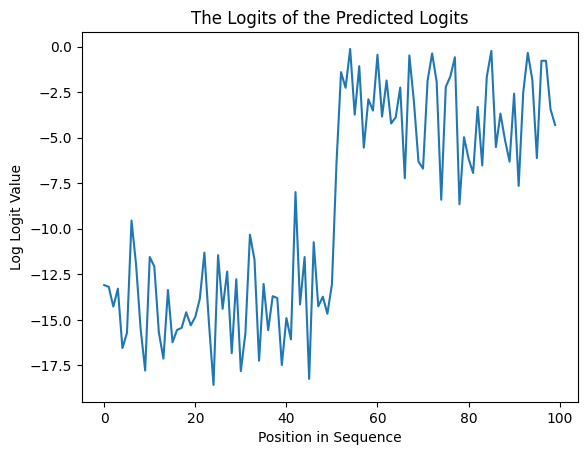

In [ ]:
plt.plot(log_probs)
plt.title("The Logits of the Predicted Logits")
plt.xlabel("Position in Sequence")
plt.ylabel("Log Logit Value")

### Visualization of the Logit of the Next Token

For each of the token, get the logit of the token that is supposed to follow. Visualization shows the logit of the next token

In [ ]:
from IPython.display import Javascript
def display_with_increased_size_colab(html, width = None, height = 300):

    '''Increase the output of the html so everything fits'''

    height_str = f"{height}px"
    width_str = f"{width}px" if width is not None else "100%"
    display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
    display(HTML(f"<div style='height: {height_str}; width: {width_str}'>{html}</div>"))


def get_next_token_logits(tokens, token_logits):
    token_next_logits = token_logits.gather(2, tokens[:, 1:].unsqueeze(-1)).squeeze(-1)
    token_next_logit = token_next_logits.squeeze(0)
    return t.cat([t.full((1,), -1e10), token_next_logit.to('cpu')], dim=0)


def get_current_token_logits(tokens, token_logits):
    token_current_logits = token_logits.gather(2, tokens.unsqueeze(-1)).squeeze(-1)
    return token_current_logits.squeeze(0)


text = 'quantum flux nebula cipher delta matrix omega spiral gamma echo epsilon quantum flux nebula cipher delta matrix omega spiral gamma echo epsilon.'

from circuitsvis.tokens import colored_tokens

tokens, token_str = generate_tokens_str(text)
token_logits, model_cache = run_and_cache_model(model, tokens)

token_next_logits = get_next_token_logits(tokens, token_logits)

display_with_increased_size_colab(colored_tokens(token_str, token_next_logits),
                                  width = 1000)



<IPython.core.display.Javascript object>